In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Загрузка данных
train_df = pd.read_excel(r'C:\Users\Mrsoning\OneDrive\Документы\GitHub\Intensive_3/train.xlsx', parse_dates=['dt'])
test_df = pd.read_excel(r'C:\Users\Mrsoning\OneDrive\Документы\GitHub\Intensive_3/test.xlsx', parse_dates=['dt'])

train_df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [20]:
train_df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [21]:
# Удаление строк с пропусками
train_df.dropna(inplace=True)

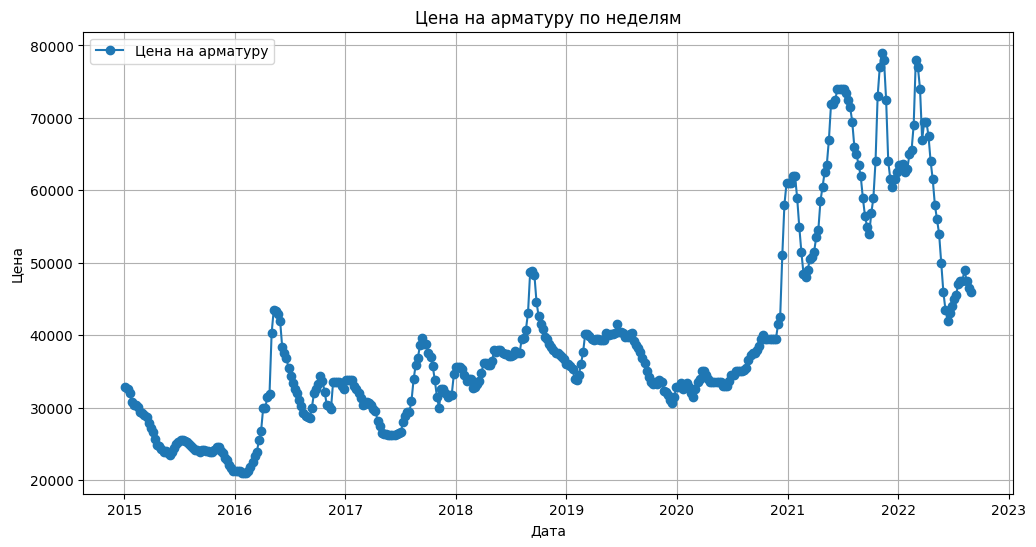

In [22]:
# Визуализация цен на арматуру
plt.figure(figsize=(12, 6))
plt.plot(train_df['dt'], train_df['Цена на арматуру'], label='Цена на арматуру', marker='o')
plt.title('Цена на арматуру по неделям')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()


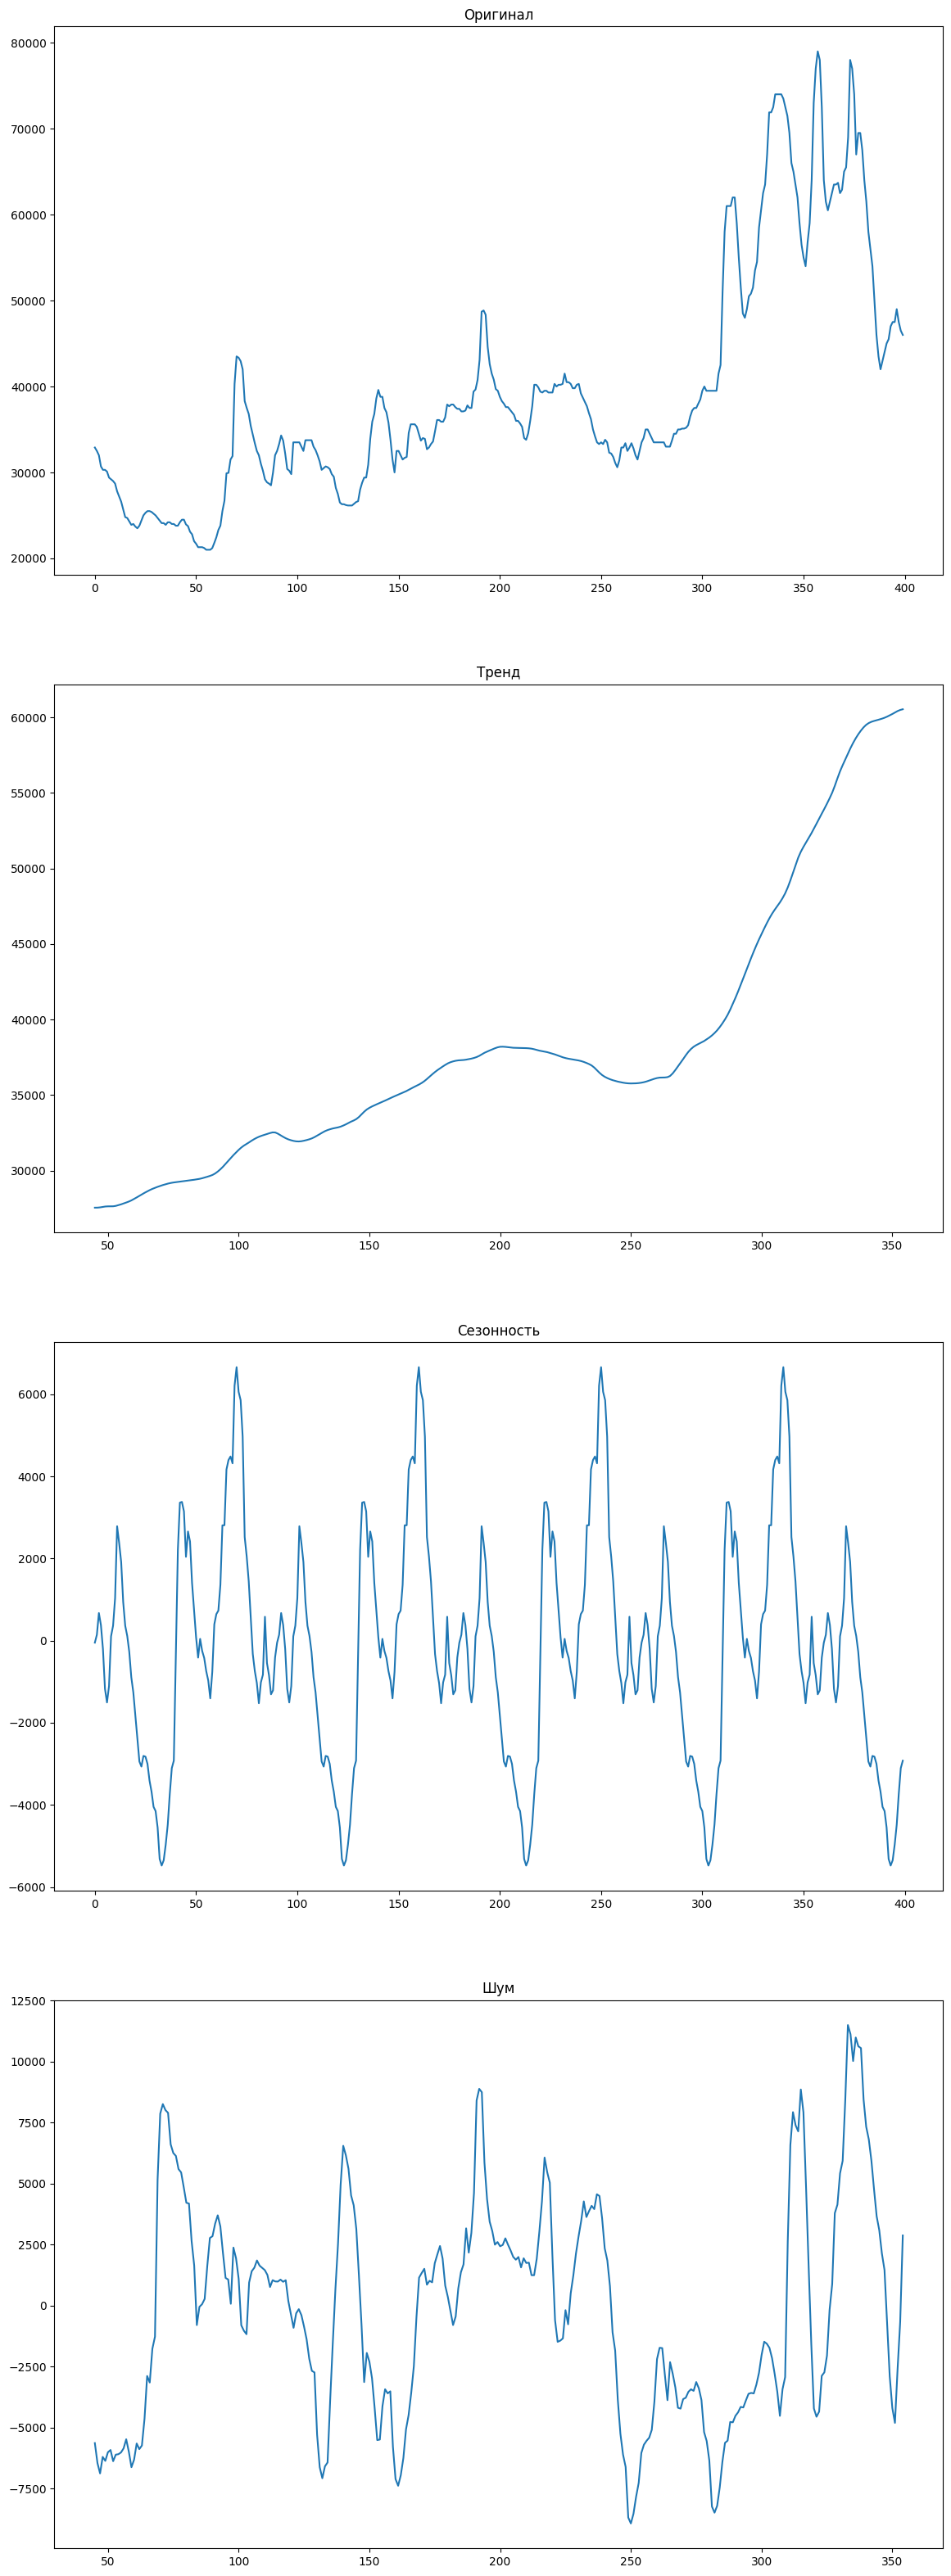

In [23]:
# Разложим ряд на компоненты и ответим: Есть ли у данного ряда тренд? Есть ли у данного ряда сезонность?
from statsmodels.tsa.seasonal import seasonal_decompose
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(train_df[['Цена на арматуру']], period=90)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [24]:
from statsmodels.tsa.stattools import acf
# Получил 'сырые' значения автокорреляций
acf(train_df['Цена на арматуру'], nlags=60, fft=False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023])

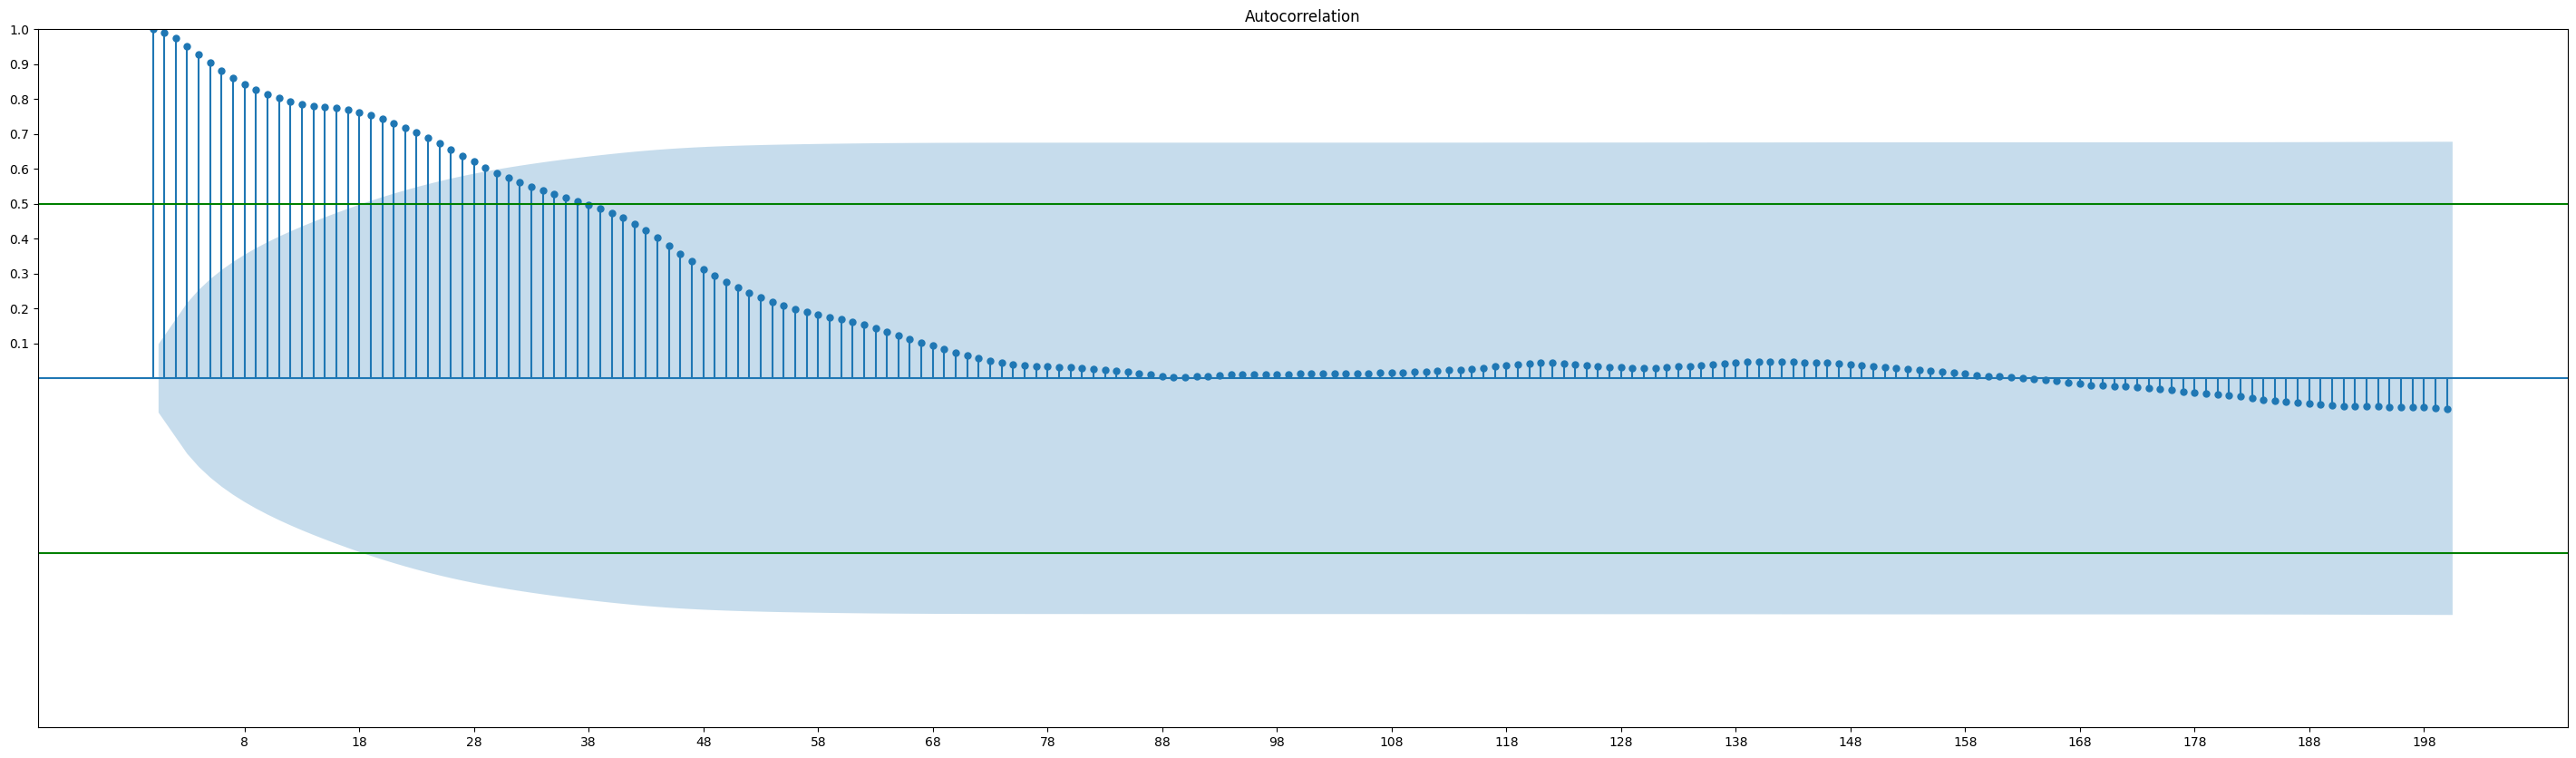

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
fig, ax = plt.subplots(figsize=(36,10))
plot_acf(train_df['Цена на арматуру'], lags=200, ax=ax)
# plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(8, 201, 10))
plt.axhline(y=0.5, color="green")
plt.axhline(y=-0.5, color="green")
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Создание признаков на основе даты
train_df['year'] = train_df['dt'].dt.year
train_df['month'] = train_df['dt'].dt.month
train_df['day_of_week'] = train_df['dt'].dt.dayofweek

test_df['year'] = test_df['dt'].dt.year
test_df['month'] = test_df['dt'].dt.month
test_df['day_of_week'] = test_df['dt'].dt.dayofweek

# Разделение данных на признаки и целевую переменную
X_train = train_df.drop(['dt', 'Цена на арматуру'], axis=1)
y_train = train_df['Цена на арматуру']
X_test = test_df.drop(['dt', 'Цена на арматуру'], axis=1)
y_test = test_df['Цена на арматуру']


# Преобразование данных в pandas Series с временным индексом
y_train = pd.Series(y_train.values, index=train_df['dt'])
y_test = pd.Series(y_test.values, index=test_df['dt'])

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Обучение модели ARIMA
try:
    model = ARIMA(y_train, order=(3, 5, 6))
    model_fit = model.fit()

    # Прогнозирование на тестовых данных
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

    # Убедитесь, что y_pred - Series с индексом из дат
    y_pred = pd.Series(y_pred, index=y_test.index)
except Exception as e:
    print(f"Ошибка при обучении/прогнозировании ARIMA: {e}")
    y_pred = pd.Series(np.zeros(len(y_test)), index=y_test.index) # or handle the error in another way


c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization f

Среднеквадратичная ошибка (MSE): 2778453.05
Средняя абсолютная ошибка (MAE): 1390.26


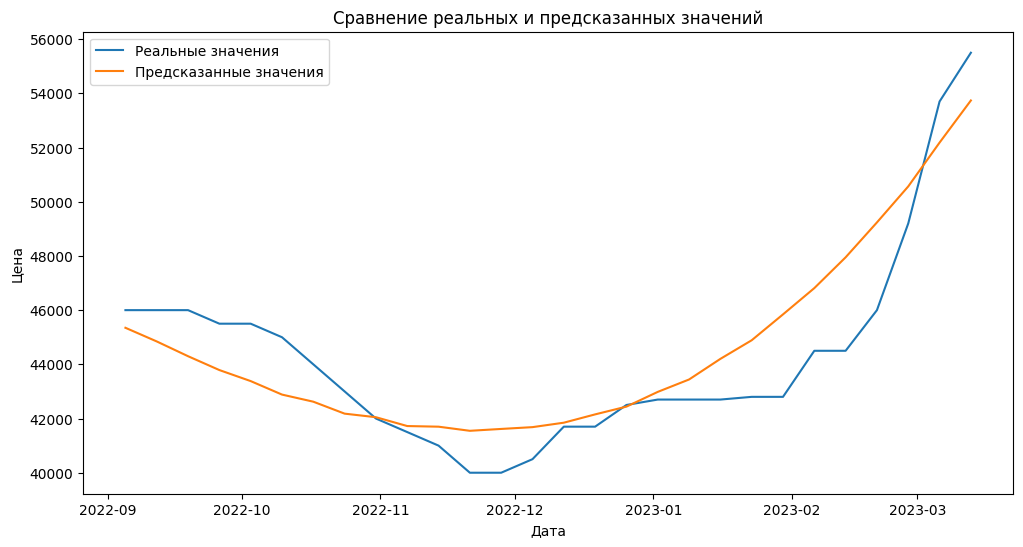

In [28]:
# Оценка модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')

# Визуализация предсказанных и реальных значений
plt.figure(figsize=(12, 6))
plt.plot(test_df['dt'], y_test, label='Реальные значения')
plt.plot(test_df['dt'], y_pred, label='Предсказанные значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()